In [1]:
import dataretrieval.nwis as nwis
import baseflow
import pandas as pd
from pathlib import Path

In [2]:
pd.set_option('max_colwidth', 800)

In [3]:
gage_path = Path('../data/Watershed_Evaluation_For_Baseflow-Runoff.csv')
gage_df = pd.read_csv(gage_path)

#usgs_gage_list = [site_no for site_no in gage_df['site_no'] if not site_no.startswith('H')]

In [4]:
usgs_gage_df = gage_df.query("Agency=='USGS'")
mn_dnr_gage_df = gage_df.query("Agency!='USGS'")
#usgs_gage_df = usgs_gage_df.loc[:,['station_nm','site_no','area_calc']]
corrected_usgs_gage_nos = ['0' + str(gageid) for gageid in usgs_gage_df['Station']]

In [5]:
usgs_gage_df['Corrected_Station_Nos'] = corrected_usgs_gage_nos


C:\Users\smwesten\AppData\Local\Temp\1\ipykernel_21456\1813597615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usgs_gage_df['Corrected_Station_Nos'] = corrected_usgs_gage_nos


In [6]:
site = usgs_gage_df['Corrected_Station_Nos'][0]
df = nwis.get_record(sites=site, service='dv', start='2000-01-01', end='2022-12-31')
df = df.rename_axis('time')


In [7]:
myQ = df['00060_Mean'].squeeze()

In [8]:
info_df = nwis.get_info(sites=[site])[0]

In [9]:
info_df.drain_area_va


0    58.9
Name: drain_area_va, dtype: float64

In [10]:
import baseflow.utils


In [11]:
Q, date = baseflow.utils.clean_streamflow(myQ)

In [12]:
b_LH = baseflow.lh(Q,beta=0.925, return_exceed=False)

In [13]:
b_LH

array([64.21396094, 64.1096875 , 64.0375    , ..., 45.555125  ,
       45.515     , 45.5       ])

In [14]:
bf_ukih = { 'UKIH': baseflow.ukih(Q,b_LH, return_exceed=False)}


In [15]:
bf_ukih

{'UKIH': array([64.21396094, 64.1096875 , 64.0375    , ..., 45.555125  ,
        45.515     , 45.5       ])}

In [16]:
baseflows = { 'UKIH': bf_ukih['UKIH'],}

In [17]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_baseflow_separation(Q, indx, baseflows, method_names=None, interactive=False):
    if method_names is None:
        method_names = list(baseflows.keys())

    if interactive:
        fig = make_subplots()
        fig.add_trace(go.Scatter(x=indx, y=Q, name='Streamflow', line=dict(width=2)))

        for method in method_names:
            if method in baseflows:
                fig.add_trace(go.Scatter(x=Q.index, y=baseflows[method], name=f'{method} Baseflow'))

        fig.update_layout(
            title='Baseflow Separation',
            xaxis_title='Date',
            yaxis_title='Flow',
            legend_title='Methods',
            hovermode="x unified",
            width=1100,
            height=600
        )

        return fig
    else:
        plt.figure(figsize=(12, 6))
        plt.plot(indx, Q, label='Observed Streamflow', alpha=0.7)

        for method in method_names:
            if method in baseflows:
                plt.plot(indx, baseflows[method], label=f'{method} Baseflow', alpha=0.7)

        plt.xlabel('Date')
        plt.ylabel('Flow')
        plt.title('Baseflow Separation')
        plt.legend()
        plt.grid(True)

        return plt.gcf()

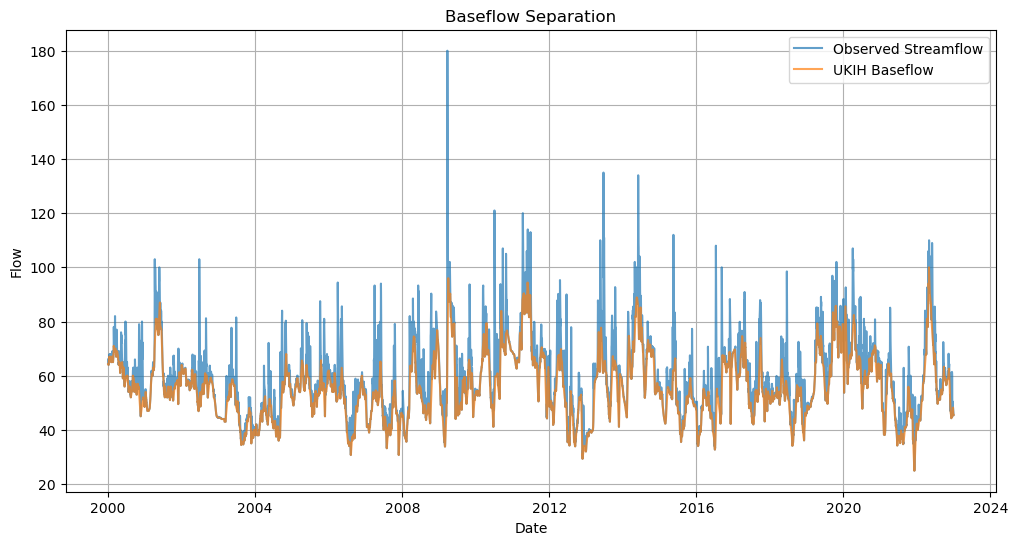

In [19]:
plot_baseflow_separation(Q=Q,indx=date,baseflows=baseflows, interactive=False)
plt.show()

In [ ]:
baseflows

In [47]:
a = 0.98
A = 0.1
bf_furey = {
    'Furey': baseflow.furey(Q[0],a, A, initial_method='Q0', return_exceed=False),
}


In [ ]:
baseflows = { 'Furey': bf_furey['Furey'],}
plot_baseflow_separation(Q=Q[0],indx=Q[1],baseflows=baseflows, interactive=False)
plt.show()